In [28]:
%matplotlib inline
import sys
sys.path.append("../lib/")
import os
import string
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.tree import plot_tree
import seaborn as sns
import graphviz
import shap

from raman_lib.visualization import (plot_spectra_peaks, 
                                     plot_qc_summary, 
                                     plot_confidence_scores, 
                                     plot_coefs, 
                                     plot_confusion_matrix, 
                                     plot_roc_curve, 
                                     plot_validation_curve,
                                     plot_roc_comparison,
                                     boxplot_comparison)

# Setup

In [29]:
dataset = "cyanos"

In [30]:
results_path = Path("../results/") / dataset
img_path = Path("../img/") / dataset

img_path.mkdir(parents=True, exist_ok=True)

In [31]:
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))

y, y_key = pd.factorize(data.label)

In [32]:
rocs = {}
aucs = {}
p_vals = {}
accs = {}
f1_scores = {}
fit_times = {}
predict_times = {}

In [33]:
plt.style.use("seaborn-paper")
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 100

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 11
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 9

# Quality Control

In [34]:
qc_results = pd.read_csv(results_path / (dataset + "_qc_scores.csv"))

qc_results.describe()

,Median Height,N Peaks
count,100.000000,100.000000
mean,1213.298845,8.270000
std,1098.295869,2.457127
min,54.461348,1.000000
25%,513.784162,7.000000
50%,913.960298,9.000000
75%,1379.186023,10.000000
max,6196.497505,19.000000


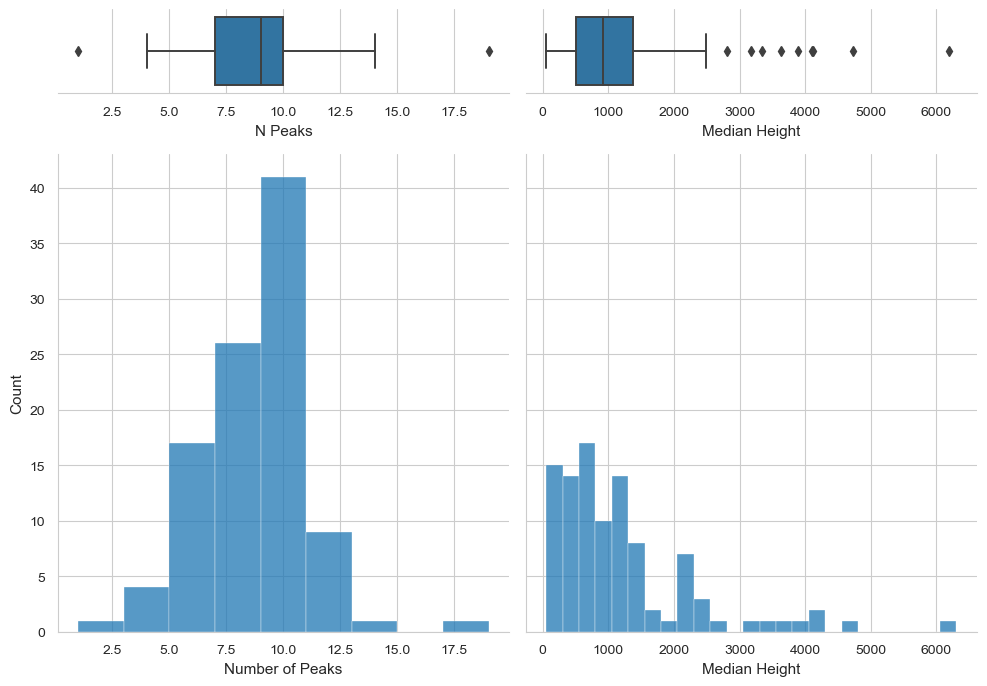

In [35]:
fig, ((ax_box1, ax_box2), (ax_hist1, ax_hist2)) = plt.subplots(
    2, 2, sharex="col", sharey="row", gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=qc_results.iloc[:,1], ax=ax_box1)
sns.boxplot(x=qc_results.iloc[:,0], ax=ax_box2)
sns.histplot(qc_results.iloc[:,1], ax=ax_hist1, binrange=None, binwidth=2)
sns.histplot(qc_results.iloc[:,0], ax=ax_hist2, binrange=None, binwidth=250)

ax_box1.set(yticks=[])
ax_box2.set(yticks=[])
sns.despine(ax=ax_hist1)
sns.despine(ax=ax_hist2)
sns.despine(ax=ax_box1, left=True)
sns.despine(ax=ax_box2, left=True)

ax_hist1.set_xlabel("Number of Peaks")
ax_hist2.set_xlabel(qc_results.columns[0])

#ax_hist1.set_ylim([None, ymax_peaks])
#ax_hist2.set_ylim([None, ymax_score])

ax_box1.tick_params(axis="x", labelbottom=True)
ax_box2.tick_params(axis="x", labelbottom=True)

fig.tight_layout()

# Dimensionality Reduction
## LDA

In [38]:
current_path = results_path / "lda_dim_reduction/lda/"
name = "LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time
count,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.000000,5.000000
mean,1.0,0.960000,1.0,0.940000,1.0,0.927778,0.061436,0.001399
std,0.0,0.089443,0.0,0.089443,0.0,0.110414,0.009493,0.000549
min,1.0,0.800000,1.0,0.800000,1.0,0.750000,0.048993,0.000997
25%,1.0,1.000000,1.0,0.900000,1.0,0.888889,0.053512,0.000999
50%,1.0,1.000000,1.0,1.000000,1.0,1.000000,0.066613,0.000999
75%,1.0,1.000000,1.0,1.000000,1.0,1.000000,0.068455,0.001999
max,1.0,1.000000,1.0,1.000000,1.0,1.000000,0.069609,0.002002


In [39]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

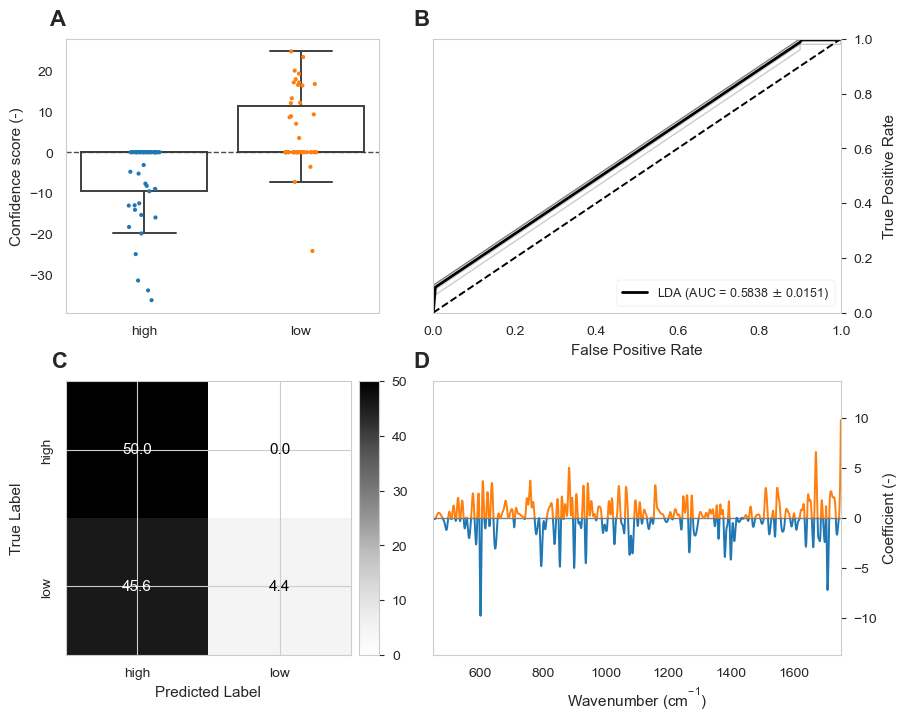

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8),
                        gridspec_kw={"width_ratios": (1, 1.3)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax2)
ax2.set_xlabel(f"False Positive Rate")
ax2.set_ylabel(f"True Positive Rate")
ax2.legend(loc="lower right")
ax2.grid()
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")

ax4 = axs[1,1]
plot_coefs(coef_df, ax=ax4)
ax4.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax4.set_ylabel("Coefficient (-)")
ax4.margins(x=0, y=0.2)
ax4.grid()
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.15, hspace=0.25)
fig.align_labels()

fig.savefig(img_path / "lda_combined.png", format="png", dpi=300, bbox_inches="tight")

## PCA-LDA

In [42]:
current_path = results_path / "lda_dim_reduction/pca_lda/"
name = "PCA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time
count,5.000000,5.0,5.000000,5.0,5.000000,5.0,5.000000,5.000000
mean,0.999605,1.0,0.991111,1.0,0.991111,1.0,0.365380,0.002000
std,0.000644,0.0,0.012172,0.0,0.012172,0.0,0.012612,0.001000
min,0.998519,1.0,0.977778,1.0,0.977778,1.0,0.350757,0.000999
25%,0.999506,1.0,0.977778,1.0,0.977778,1.0,0.356650,0.001000
50%,1.000000,1.0,1.000000,1.0,1.000000,1.0,0.362848,0.002000
75%,1.000000,1.0,1.000000,1.0,1.000000,1.0,0.376787,0.002995
max,1.000000,1.0,1.000000,1.0,1.000000,1.0,0.379861,0.003005


In [43]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

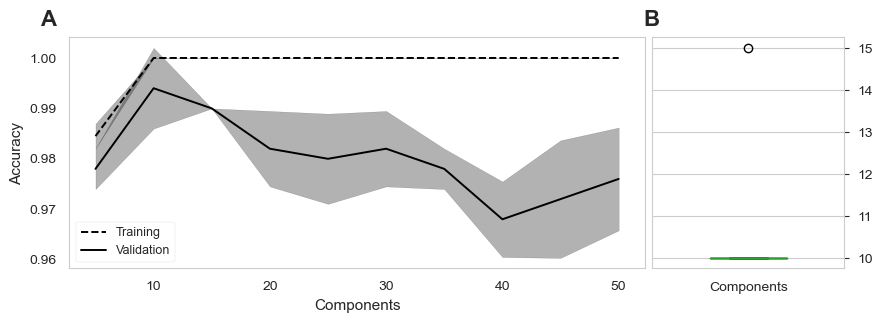

In [44]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Components")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Components"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "pcalda_validation.png", format="png", dpi=300, bbox_inches="tight")

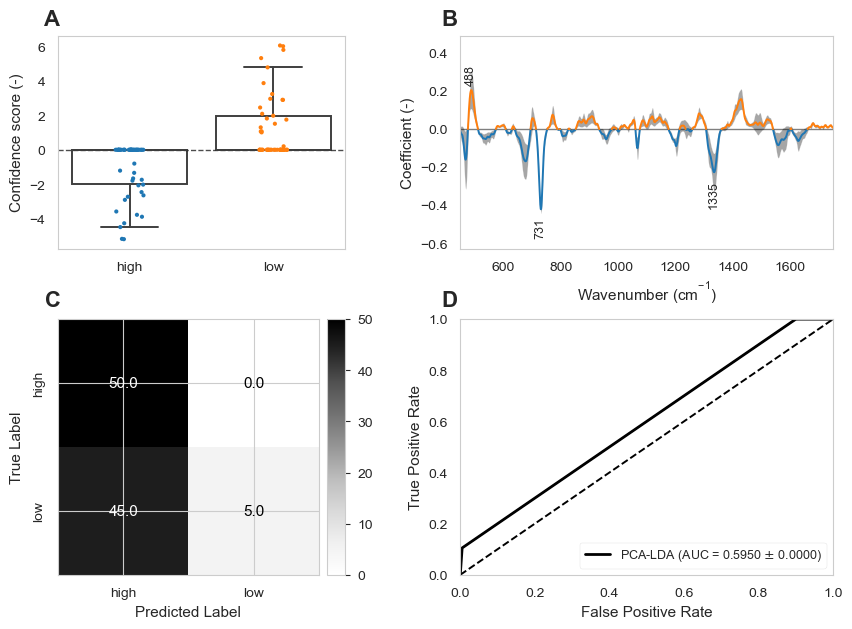

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 0.2, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "pcalda_combined.png", format="png", dpi=300, bbox_inches="tight")

## NMF-LDA

In [16]:
current_path = results_path / "lda_dim_reduction/nmf_lda/"
name = "NMF-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00
mean,0.999850,0.998800,0.993500,0.984000,0.993430,0.983779,0.606754,0.006009,2.078161e-11
std,0.000056,0.001095,0.003354,0.005477,0.003368,0.005198,0.011229,0.001752,1.255789e-11
min,0.999750,0.998000,0.987500,0.980000,0.987405,0.979950,0.590473,0.003604,7.025137e-12
25%,0.999875,0.998000,0.995000,0.980000,0.994937,0.980000,0.599686,0.005600,7.025137e-12
50%,0.999875,0.998000,0.995000,0.980000,0.994937,0.980000,0.613393,0.005727,2.995260e-11
75%,0.999875,1.000000,0.995000,0.990000,0.994937,0.989474,0.613434,0.006703,2.995260e-11
max,0.999875,1.000000,0.995000,0.990000,0.994937,0.989474,0.616785,0.008410,2.995260e-11


In [17]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

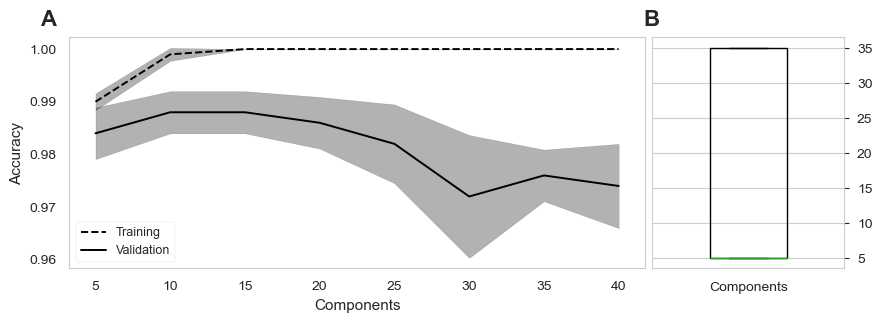

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Components")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Components"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "nmflda_validation.png", format="png", dpi=300, bbox_inches="tight")

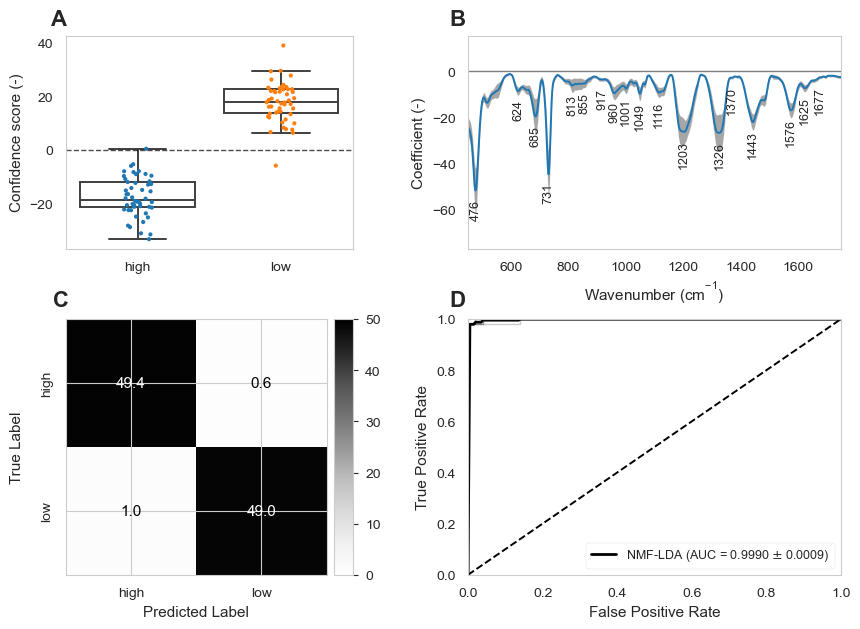

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 2.5, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "nmflda_combined.png", format="png", dpi=300, bbox_inches="tight")

## Feature Agglomeration (FA) - LDA

In [20]:
current_path = results_path / "lda_dim_reduction/fa_lda/"
name = "FA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00
mean,0.999475,0.997200,0.982000,0.960000,0.981637,0.958449,9.815208,0.001721,1.416626e-10
std,0.000224,0.001095,0.004809,0.007071,0.005018,0.006323,3.808726,0.000228,1.214029e-10
min,0.999125,0.996000,0.975000,0.950000,0.974216,0.949424,3.087970,0.001401,1.949052e-11
25%,0.999500,0.996000,0.980000,0.960000,0.979810,0.957728,10.818357,0.001602,8.292839e-11
50%,0.999500,0.998000,0.982500,0.960000,0.982144,0.958897,11.139696,0.001798,8.292839e-11
75%,0.999500,0.998000,0.985000,0.960000,0.984610,0.958947,11.608177,0.001804,1.966160e-10
max,0.999750,0.998000,0.987500,0.970000,0.987402,0.967251,12.421840,0.002002,3.263497e-10


In [21]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

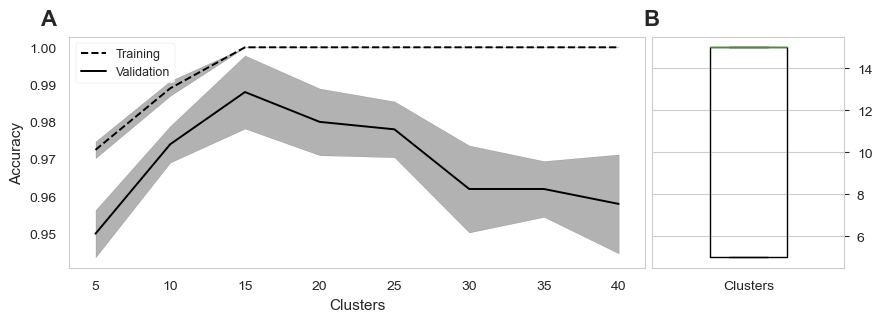

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Clusters")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Clusters"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "falda_validation.png", format="png", dpi=300, bbox_inches="tight")

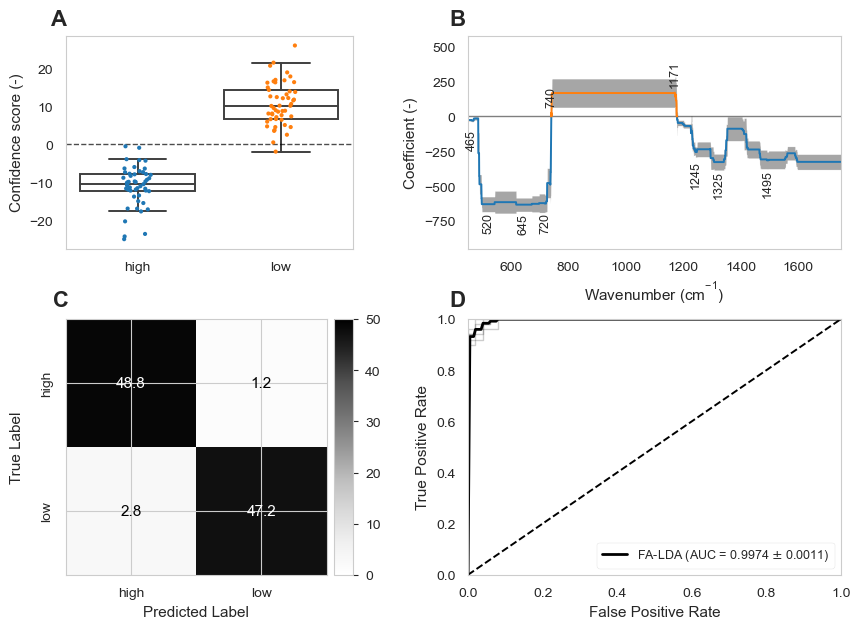

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 20, 
                                                                      "min_dist": 100,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "falda_combined.png", format="png", dpi=300, bbox_inches="tight")

## Peak-LDA

In [24]:
current_path = results_path / "lda_dim_reduction/peak_lda/"
name = "Peak-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00
mean,0.999975,0.988800,0.998000,0.950000,0.997962,0.947224,0.316842,0.002086,7.028837e-10
std,0.000056,0.008672,0.002739,0.017321,0.002791,0.017585,0.031518,0.000229,1.430728e-09
min,0.999875,0.976000,0.995000,0.920000,0.994872,0.917895,0.296329,0.001800,3.247490e-11
25%,1.000000,0.984000,0.995000,0.950000,0.994937,0.943653,0.302321,0.002000,5.412161e-11
50%,1.000000,0.992000,1.000000,0.960000,1.000000,0.956725,0.303126,0.002015,8.292839e-11
75%,1.000000,0.996000,1.000000,0.960000,1.000000,0.958897,0.309869,0.002218,8.292839e-11
max,1.000000,0.996000,1.000000,0.960000,1.000000,0.958947,0.372565,0.002399,3.261965e-09


In [25]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

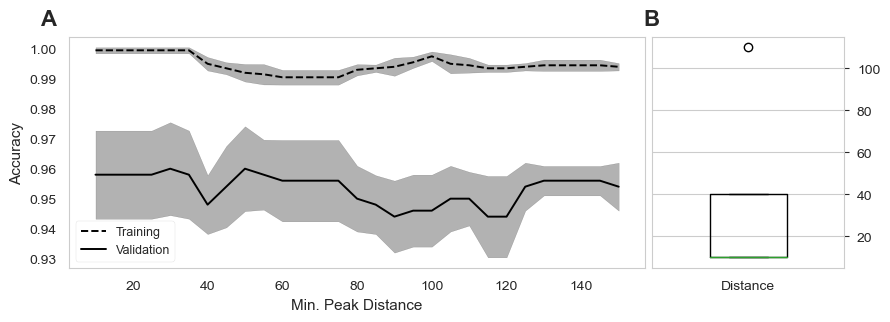

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Min. Peak Distance")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Distance"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "peaklda_validation.png", format="png", dpi=300, bbox_inches="tight")

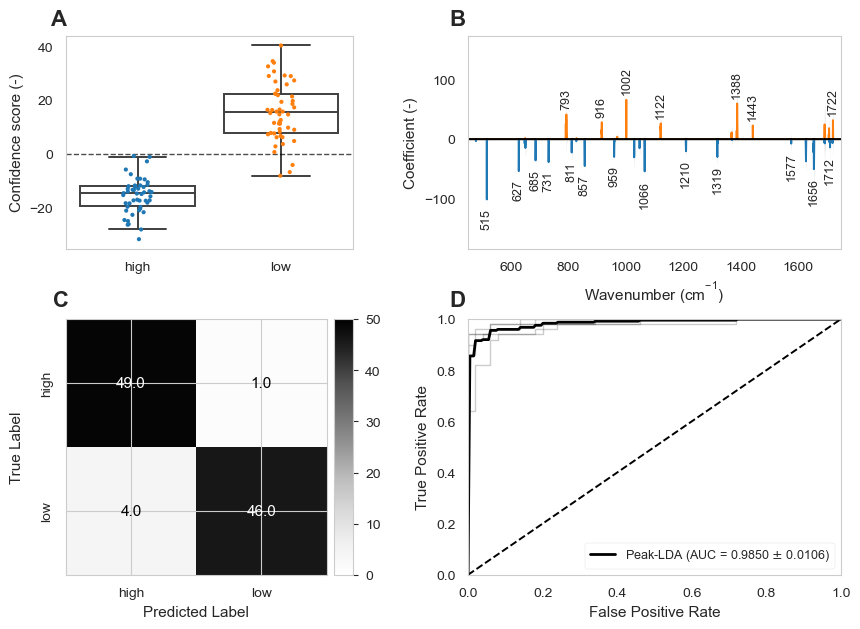

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 2.5, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "peaklda_combined.png", format="png", dpi=300, bbox_inches="tight")

## Comparison of LDA with different dimensionality Reductions

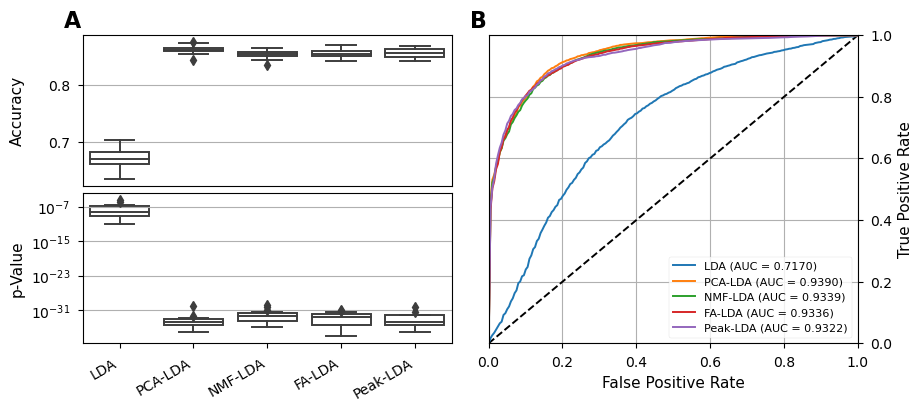

In [28]:
fig = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="LDA", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="LDA", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="LDA")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")
    
fig.align_ylabels()

fig.savefig(img_path / "lda_comparison.png", format="png", dpi=300, bbox_inches="tight")

# Regularized Models
## Logistic Regression (L1)

In [29]:
current_path = results_path / "regularized_models/logreg_l1/"
name = "Log. Reg. (L1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.981950,0.951950,0.936250,0.877250,0.936075,0.877656,2.161535,0.007261,1.310649e-36
std,0.003759,0.003849,0.008036,0.006450,0.008035,0.006466,0.042461,0.003152,3.777092e-36
min,0.973483,0.944000,0.918750,0.863333,0.918606,0.863540,2.091892,0.004107,2.617155e-41
25%,0.980023,0.949611,0.932292,0.876250,0.932040,0.877221,2.128112,0.004944,3.288828e-39
50%,0.981972,0.952222,0.937708,0.880000,0.937445,0.879423,2.157715,0.005937,9.498476e-39
75%,0.983354,0.954833,0.939167,0.880417,0.939036,0.881012,2.202660,0.008668,1.171357e-37
max,0.992198,0.958889,0.960417,0.888333,0.960300,0.888416,2.220105,0.013881,1.473935e-35


In [30]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

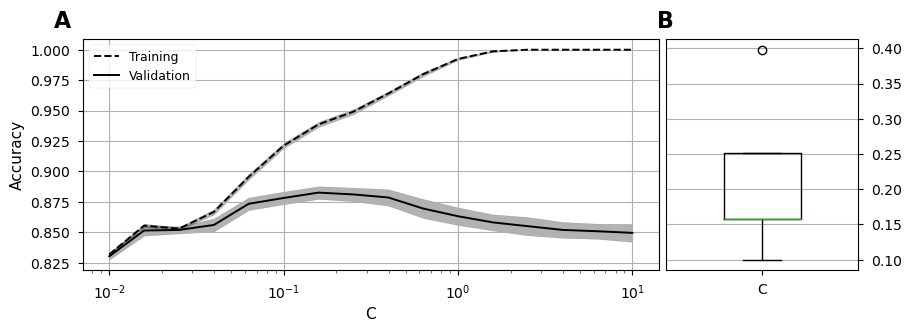

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "logreg_l1_validation.png", format="png", dpi=300, bbox_inches="tight")

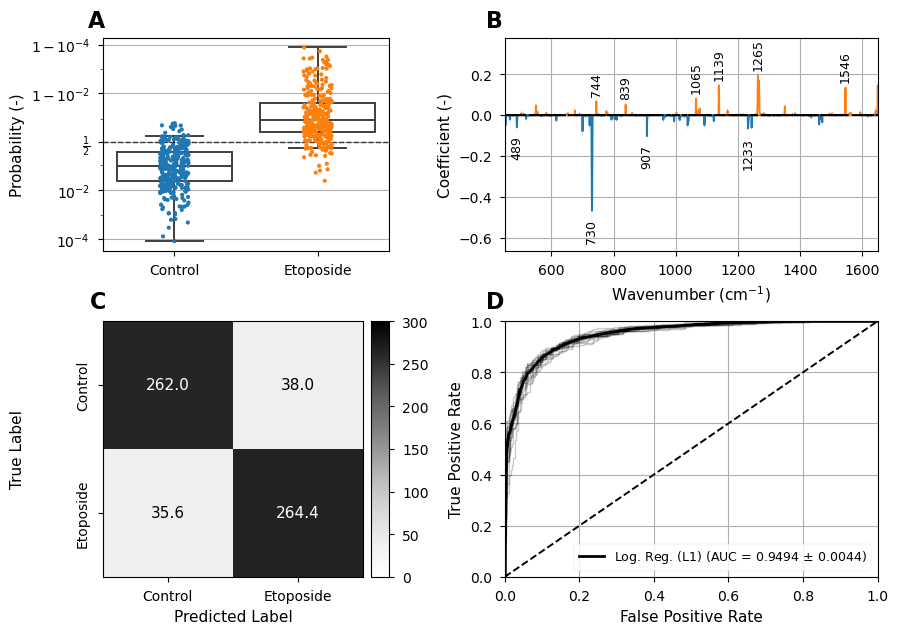

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 0.05, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.15)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "logreg_l1_combined.png", format="png", dpi=300, bbox_inches="tight")

## Logistic Regression (L2)

In [33]:
current_path = results_path / "regularized_models/logreg_l2/"
name = "Log. Reg. (L2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.986441,0.938764,0.942271,0.858167,0.942277,0.858448,3.134381,0.008798,1.490096e-33
std,0.002416,0.003710,0.007959,0.006902,0.007950,0.006587,0.085595,0.002032,3.222040e-33
min,0.981240,0.932222,0.926667,0.848333,0.926638,0.849067,2.957229,0.005668,3.238630e-38
25%,0.985024,0.936694,0.936667,0.853333,0.936777,0.853430,3.071039,0.007498,4.242017e-36
50%,0.986521,0.938750,0.942917,0.856667,0.942948,0.857392,3.143827,0.008458,1.172389e-34
75%,0.988097,0.940694,0.948542,0.861667,0.948755,0.861490,3.171430,0.009900,7.425252e-34
max,0.989955,0.947944,0.954583,0.875000,0.954495,0.875912,3.345397,0.013905,1.075157e-32


In [34]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

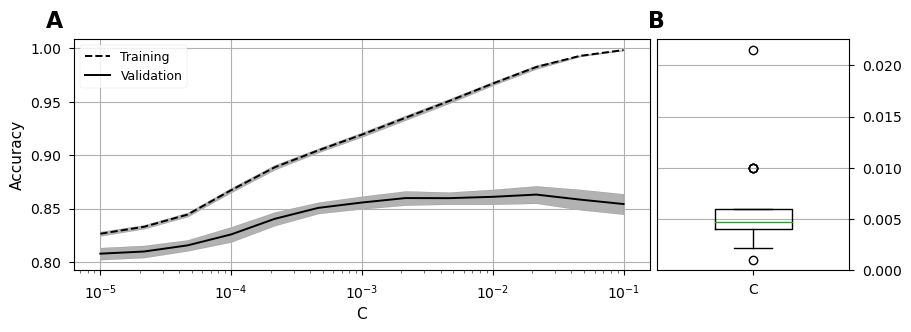

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "logreg_l2_validation.png", format="png", dpi=300, bbox_inches="tight")

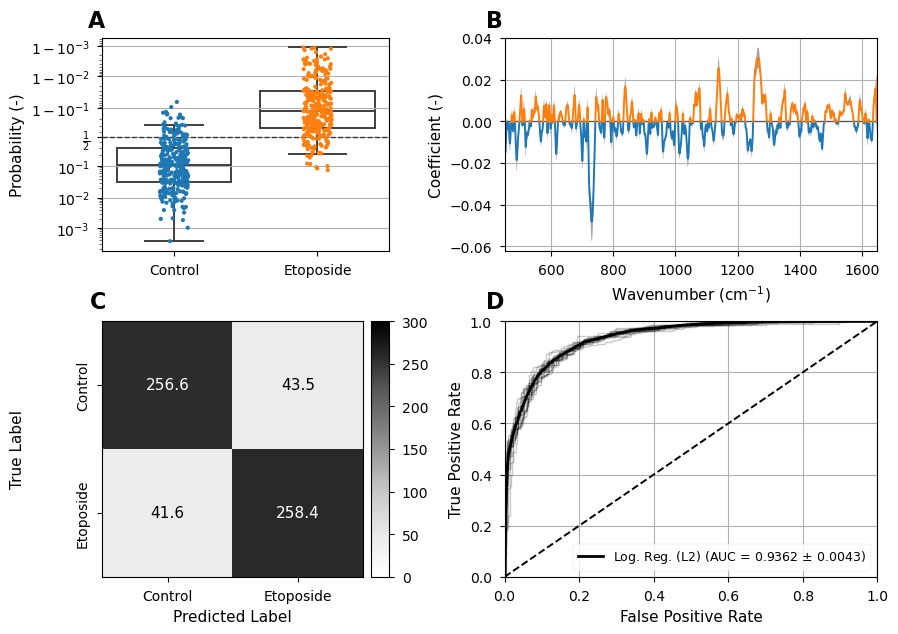

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True)
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.05)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "logreg_l2_combined.png", format="png", dpi=300, bbox_inches="tight")

## Support Vector Machine (L1)

In [37]:
current_path = results_path / "regularized_models/svm_l1/"
name = "SVM (L1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.981326,0.951769,0.933958,0.877917,0.934013,0.878809,3.950003,0.007701,6.105582e-37
std,0.003337,0.003872,0.007041,0.006441,0.006988,0.006491,0.086029,0.002339,1.479944e-36
min,0.974854,0.944944,0.920000,0.866667,0.920036,0.866024,3.842358,0.004619,1.851873e-41
25%,0.979559,0.949347,0.930313,0.872917,0.930332,0.874138,3.867519,0.005708,2.919194e-39
50%,0.981212,0.952083,0.933542,0.876667,0.933693,0.878197,3.948835,0.007357,1.659951e-38
75%,0.983155,0.953569,0.937708,0.883333,0.937622,0.884084,3.995047,0.009049,5.178069e-37
max,0.989451,0.958944,0.948750,0.891667,0.948547,0.892091,4.149630,0.011744,6.446185e-36


In [38]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

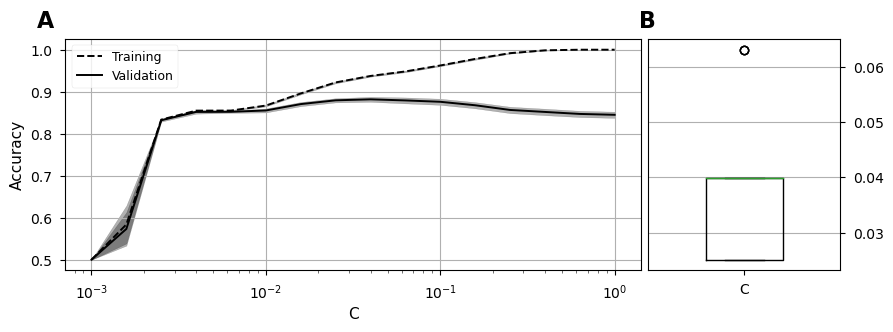

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "svm_l1_validation.png", format="png", dpi=300, bbox_inches="tight")

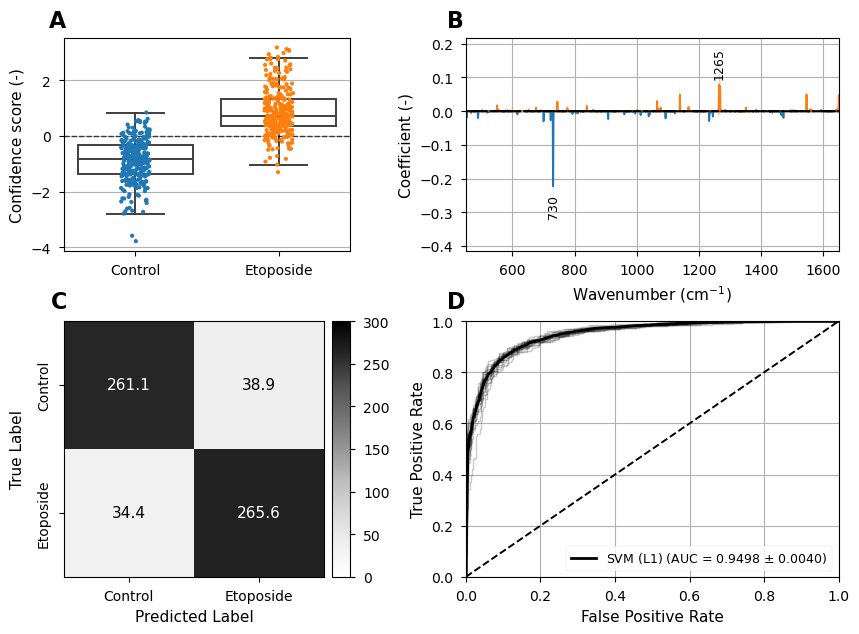

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 0.05, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.15)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "svm_l1_combined.png", format="png", dpi=300, bbox_inches="tight")

## Support Vector Machine (L2)

In [41]:
current_path = results_path / "regularized_models/svm_l2/"
name = "SVM (L2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.984814,0.937383,0.936937,0.856167,0.937147,0.857104,2.579449,0.007104,3.823097e-33
std,0.003345,0.004498,0.009349,0.005596,0.009343,0.005645,0.082277,0.002625,9.669163e-33
min,0.978847,0.929222,0.922500,0.846667,0.922659,0.848305,2.466345,0.003843,1.207958e-36
25%,0.981813,0.936069,0.929792,0.851250,0.929993,0.852401,2.506225,0.005080,8.984460e-35
50%,0.985373,0.938000,0.937708,0.856667,0.937901,0.857644,2.564504,0.007224,2.493907e-34
75%,0.987380,0.939486,0.943438,0.860000,0.943772,0.861289,2.651092,0.008490,1.951954e-33
max,0.989833,0.946722,0.957917,0.866667,0.957921,0.866388,2.710277,0.014549,4.161836e-32


In [42]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

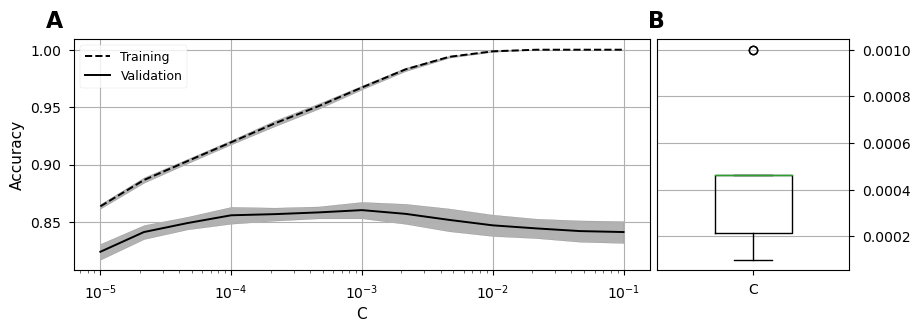

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "svm_l2_validation.png", format="png", dpi=300, bbox_inches="tight")

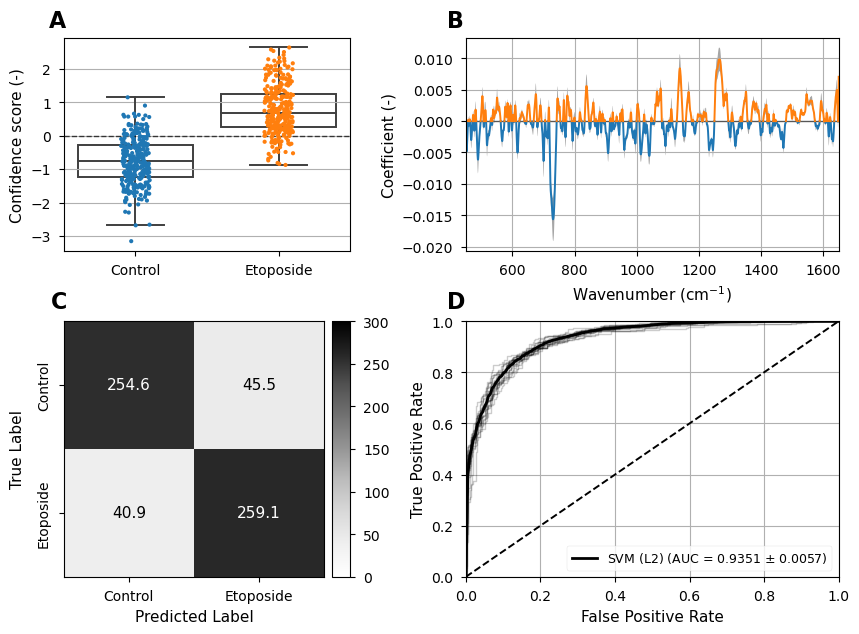

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True)
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.05)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "svm_l2_combined.png", format="png", dpi=300, bbox_inches="tight")

## Comparison of Regularized Models (Logistic Regression and Linear SVM)

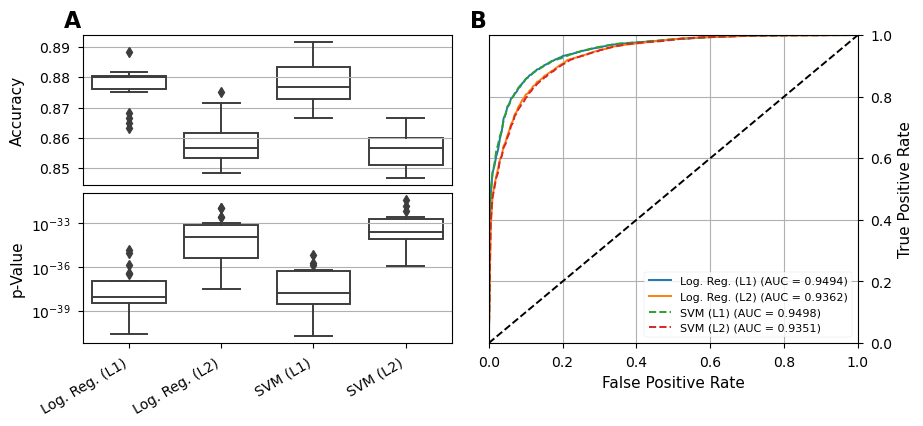

In [45]:
fig = plt.figure(figsize=(10, 4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="Log. Reg.|SVM", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="Log. Reg.|SVM", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="Log. Reg.|SVM")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")

ax3.lines[3].set_linestyle('--')
ax3.lines[4].set_linestyle('--')

ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")
    
fig.align_ylabels()

fig.savefig(img_path / "linear_comparison.png", format="png", dpi=300, bbox_inches="tight")

# Tree-based Models
## Decision Tree

In [46]:
current_path = results_path / "tree_based_models/decision_tree/"
name = "Decision Tree"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.923453,0.895258,0.909000,0.872333,0.904195,0.865190,2.830352,0.002062,2.194838e-36
std,0.008151,0.009062,0.006864,0.008709,0.006689,0.009169,0.092367,0.000181,9.808024e-36
min,0.900939,0.883417,0.891250,0.850000,0.888010,0.846388,2.693407,0.001863,1.930557e-45
25%,0.921264,0.884840,0.907917,0.866667,0.902657,0.857640,2.744270,0.001940,3.731169e-43
50%,0.925685,0.896708,0.910833,0.873333,0.905859,0.866553,2.828222,0.002015,2.317424e-42
75%,0.927836,0.899951,0.912500,0.878333,0.907497,0.871658,2.908900,0.002162,2.536175e-41
max,0.935901,0.914861,0.918333,0.885000,0.914406,0.879115,2.982619,0.002574,4.386450e-35


In [47]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

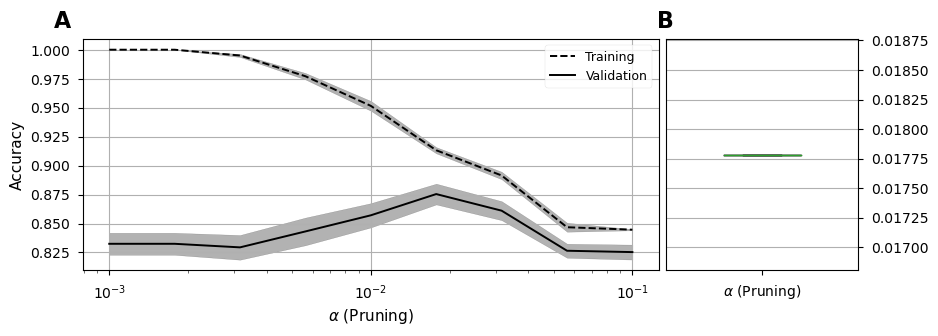

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel(r"$\alpha$ (Pruning)")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels([r"$\alpha$ (Pruning)"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "tree_validation.png", format="png", dpi=300, bbox_inches="tight")

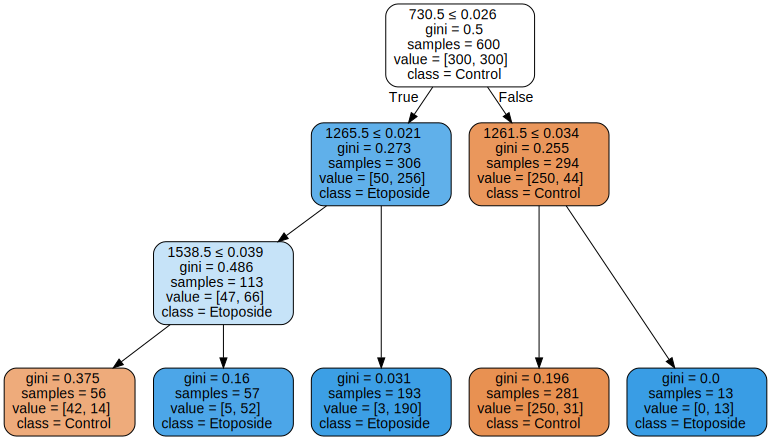

In [49]:
tree = graphviz.Source.from_file(current_path / "tree.dot")
tree.render(img_path / "tree", format="png")
tree

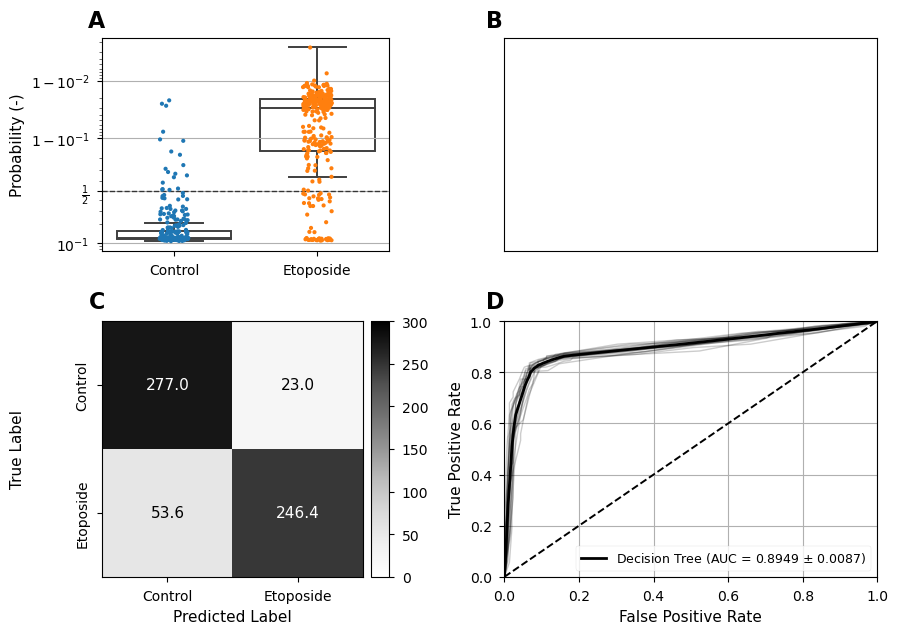

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "tree_combined.png", format="png", dpi=300, bbox_inches="tight")

## Random Forest

In [51]:
current_path = results_path / "tree_based_models/random_forest/"
name = "Random Forest"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.985932,0.951383,0.928542,0.884833,0.926161,0.879514,3.478377,0.002642,1.206449e-40
std,0.000399,0.002588,0.002762,0.006091,0.002942,0.006164,0.138045,0.000484,5.355988e-40
min,0.985198,0.945444,0.923750,0.868333,0.921130,0.863822,3.340555,0.002109,5.855282e-46
25%,0.985661,0.949736,0.927396,0.882917,0.924916,0.877083,3.375244,0.002276,1.561016e-44
50%,0.986012,0.951694,0.928333,0.885000,0.925795,0.880324,3.400553,0.002414,8.742098e-44
75%,0.986299,0.953000,0.928958,0.888333,0.926800,0.881744,3.579529,0.002885,3.876065e-43
max,0.986531,0.955611,0.935000,0.895000,0.932752,0.890274,3.787640,0.003669,2.396134e-39


In [52]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

### XAI - shap
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)
shap_val_df = pd.DataFrame(data=np.absolute(shap_vals), columns=shap_features)

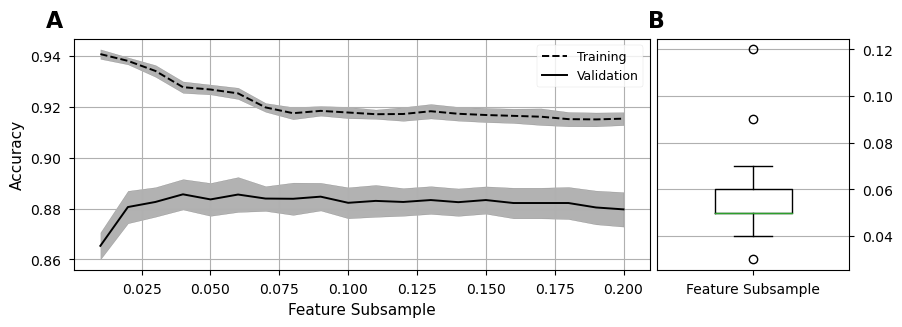

In [53]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)
ax1.set_xlabel("Feature Subsample")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Feature Subsample"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "forest_validation.png", format="png", dpi=300, bbox_inches="tight")

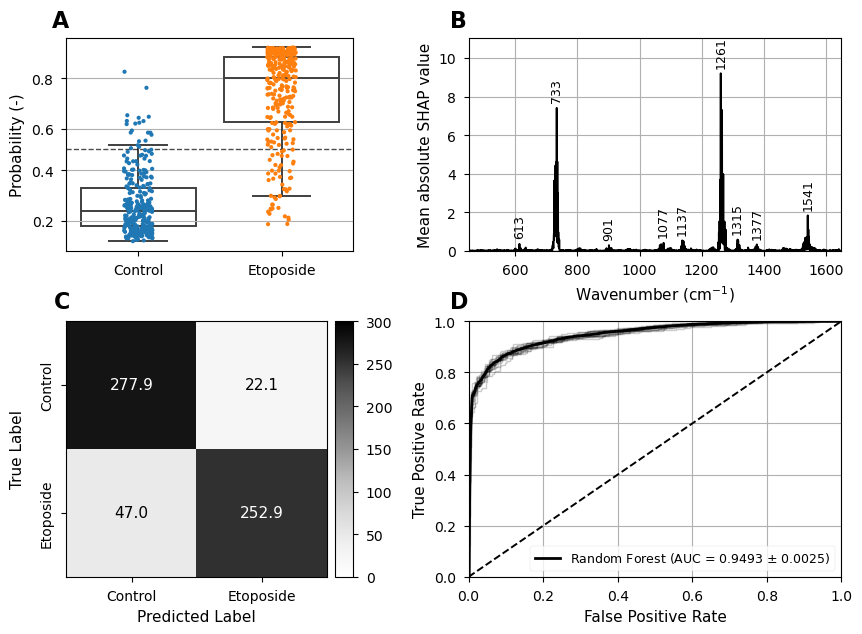

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(shap_val_df, ax=ax2, col=False, annotate=True, annot_kw={"min_height": 0.25, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})

ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Mean absolute SHAP value")
ax2.margins(x=0, y=0.2)
ax2.set_ylim(0, None)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "forest_combined.png", format="png", dpi=300, bbox_inches="tight")

### Explainable AI - SHAP

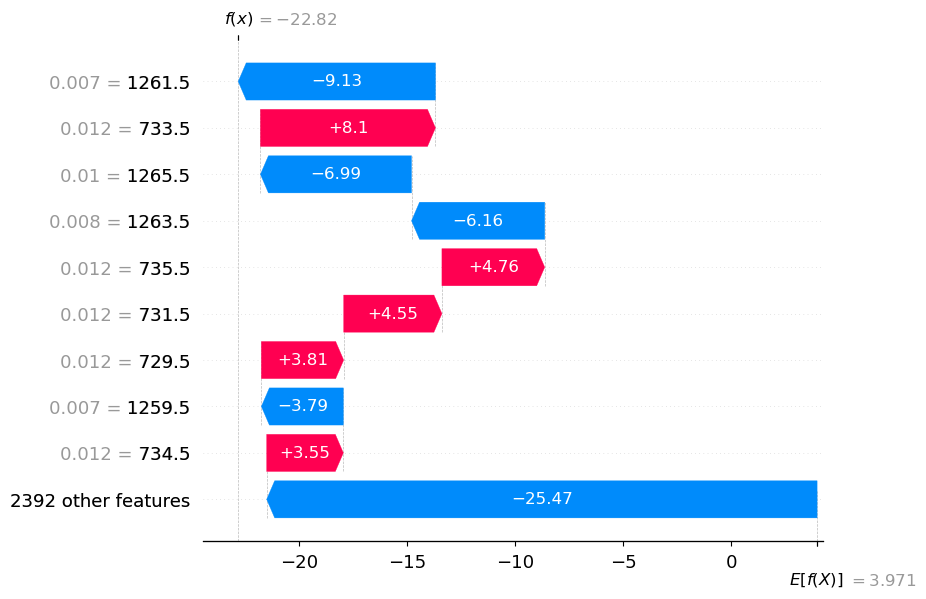

In [55]:
fig, ax = plt.subplots()
first_expl = explanation[5]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

fig.savefig(img_path / "forest_shap_waterfall.png", format="png", dpi=300, bbox_inches="tight")

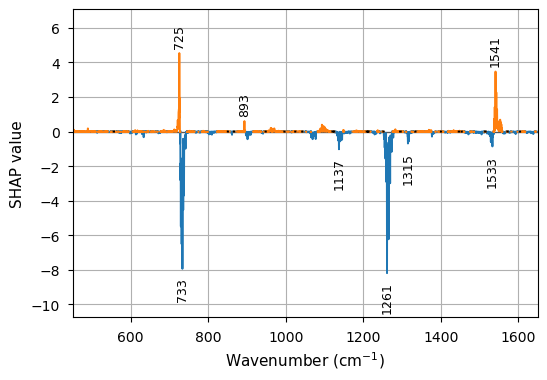

In [56]:
fig, ax = plt.subplots(figsize=(6,4))
plot_coefs(pd.Series(shap_vals[1,:], index=shap_features), ax=ax, annotate=True, annot_kw={"min_height": 0.5, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})
ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("SHAP value")
ax.margins(x=0, y=0.2)
ax.grid()

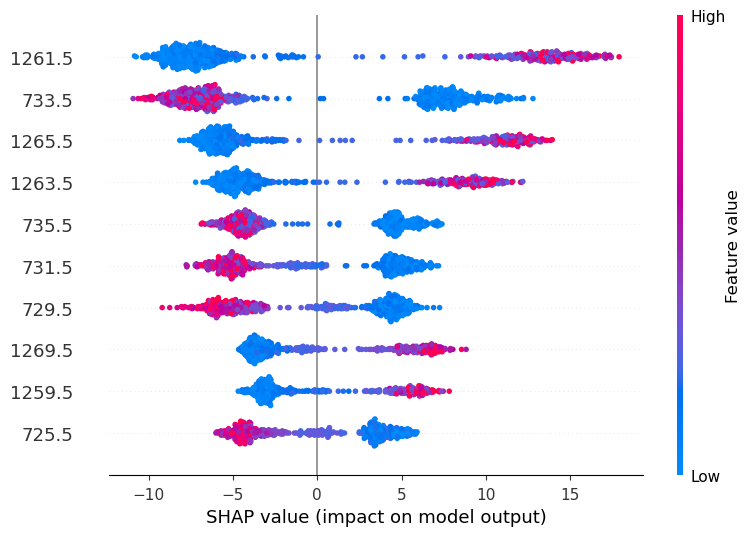

In [57]:
fig, ax = plt.subplots()
shap.summary_plot(explanation, feature_names=shap_features, max_display=10)

fig.savefig(img_path / "forest_shap.png", format="png", dpi=300, bbox_inches="tight")

## Gradient Boosted Trees

In [58]:
current_path = results_path / "tree_based_models/gbdt/"
name = "Gradient-boost"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.0,20.000000,20.0,20.000000,20.0,20.000000,20.000000,20.000000,2.000000e+01
mean,1.0,0.965656,1.0,0.901250,1.0,0.898423,5.105299,0.002489,6.601476e-44
std,0.0,0.002344,0.0,0.007412,0.0,0.007556,0.031530,0.000462,1.893500e-43
min,1.0,0.962167,1.0,0.890000,1.0,0.886158,5.057269,0.002091,2.110011e-49
25%,1.0,0.964319,1.0,0.895000,1.0,0.892214,5.081789,0.002218,7.101982e-47
50%,1.0,0.965583,1.0,0.901667,1.0,0.898331,5.105205,0.002306,1.187901e-45
75%,1.0,0.966889,1.0,0.903750,1.0,0.900875,5.123377,0.002640,1.661003e-44
max,1.0,0.971611,1.0,0.916667,1.0,0.914089,5.180459,0.004093,7.996375e-43


In [59]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

### XAI - shap
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

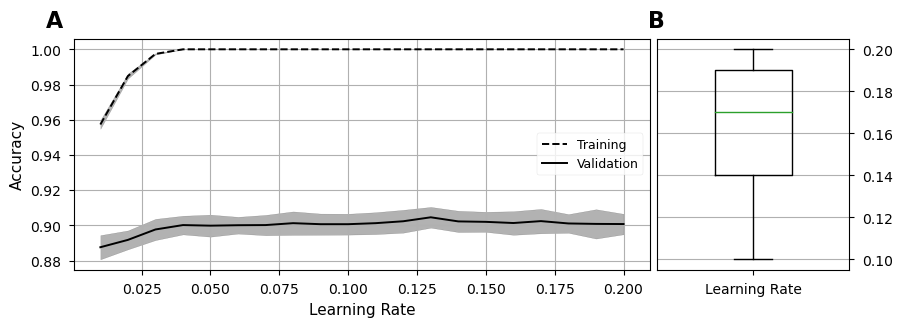

In [60]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Learning Rate"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "gbdt_validation.png", format="png", dpi=300, bbox_inches="tight")

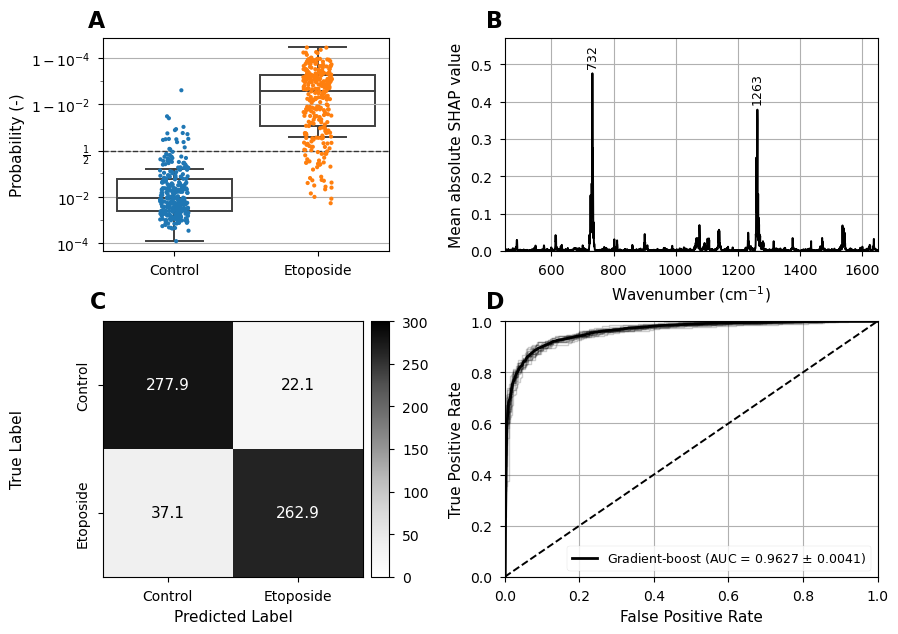

In [61]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(shap_val_df, ax=ax2, col=False, annotate=True, annot_kw={"min_height": 0.25, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})

ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Mean absolute SHAP value")
ax2.margins(x=0, y=0.2)
ax2.set_ylim(0, None)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "gbdt_combined.png", format="png", dpi=300, bbox_inches="tight")

### Explainable AI - SHAP

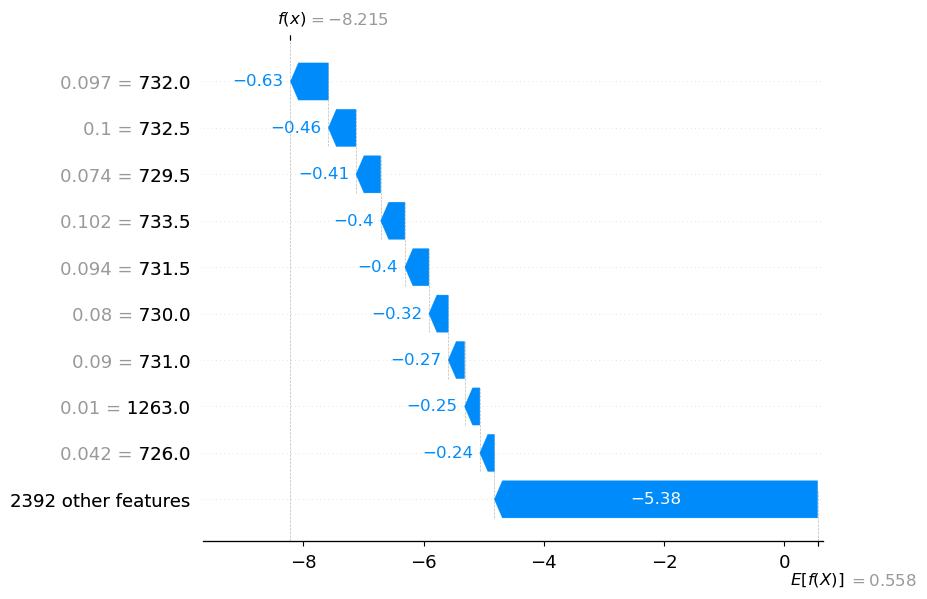

In [62]:
fig, ax = plt.subplots()
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

fig.savefig(img_path / "gbdt_shap_waterfall.png", format="png", dpi=300, bbox_inches="tight")

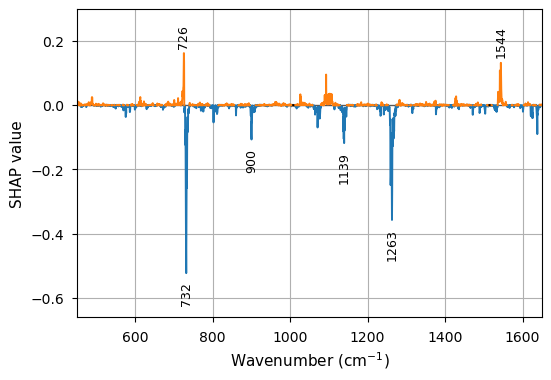

In [63]:
fig, ax = plt.subplots(figsize=(6,4))
plot_coefs(pd.Series(shap_vals[1,:], index=shap_features), ax=ax, annotate=True, annot_kw={"min_height": 0.1, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})
ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("SHAP value")
ax.margins(x=0, y=0.2)
ax.grid()

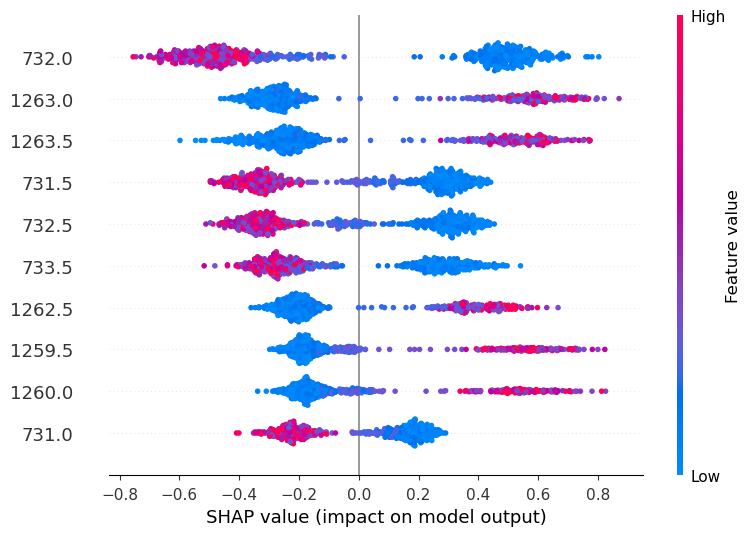

In [64]:
fig, ax = plt.subplots()
shap.summary_plot(explanation, feature_names=shap_features, max_display=10)

fig.savefig(img_path / "gbdt_shap.png", format="png", dpi=300, bbox_inches="tight")

## Comparison of Tree-based Models

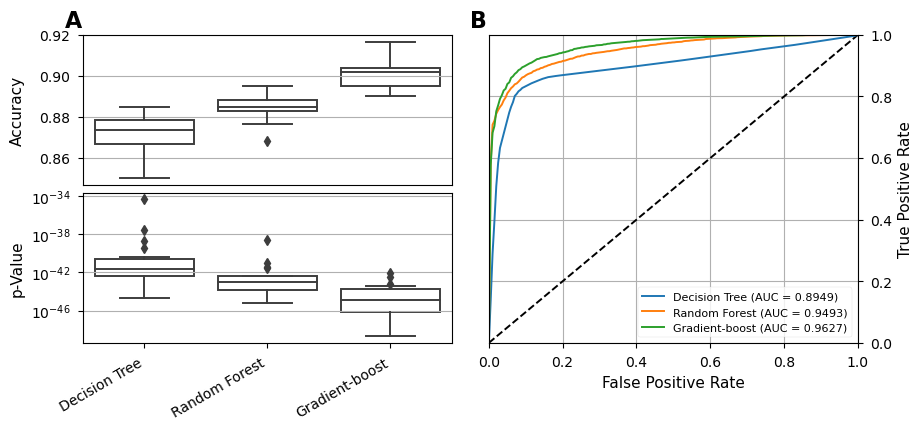

In [65]:
fig = plt.figure(figsize=(10, 4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="Tree|Forest|Gradient", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="Tree|Forest|Gradient", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="Tree|Forest|Gradient")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")

fig.align_ylabels()

fig.savefig(img_path / "tree_comparison.png", format="png", dpi=300, bbox_inches="tight")

## Overall Comparison

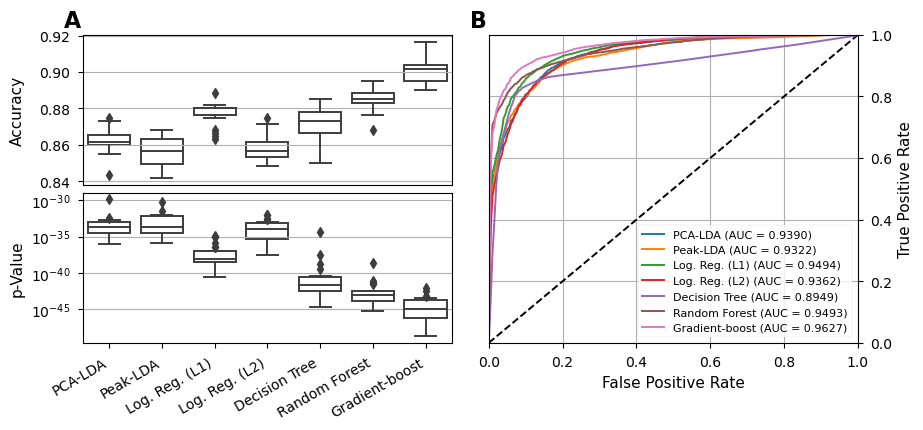

In [66]:
fig = plt.figure(figsize=(10, 4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")

fig.align_ylabels()

fig.savefig(img_path / "all_comparison.png", format="png", dpi=300, bbox_inches="tight")